# Compare Gemini 2.5 Models

<a target="_blank" href="https://colab.research.google.com/github/patrickloeber/workshop-build-with-gemini/blob/main/06-gemini-2-5-evaluations.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook overview

In this notebook we'll compare Gemini 2.5 Pro, Gemini 2.5 Flash, and Gemini 2.5 Flash-Lite on a few tasks, with and without thinking.

- Run prompt with all models
- 🔢Calculate tokens
- 💰Calculate prices
- 🚀Calculate speed
- 🤔Apply thinking config
- 💪Measure PDF extraction accuracy
- 📊Plot the evals
- 🚄Calculate TTFT with streaming
- Test 1: PDF Invoice data extraction
- Test 2: Chat with large PDF
- Test 3: Generate an SVG of a pelican riding a bicycle
- TBD: (Test 4: audio transcription)

### High level 2.5 models overview:

![Gemini 2.5 overview](data/gemini-2-5-overview.png)

### Gemini 2.5 benchmarks:

![Gemini 2.5 benchmarks](https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/gemini_2-5_benchmarks_margin_light2x_1.gif)

## Setup

Get a free API key in the [Google AI Studio](https://aistudio.google.com/apikey) and set up the [Google Gen AI Python SDK](https://github.com/googleapis/python-genai)

In [24]:
%pip install -U -q google-genai datasets matplotlib Pillow python-dotenv


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import io
import os
import sys
import json
from pathlib import Path
import statistics
import time
from PIL import Image # pip install Pillow

In [8]:
from google import genai  # pip install -U google-genai
from google.genai import types

if 'google.colab' in sys.modules:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
else:
    from dotenv import load_dotenv; load_dotenv()
    GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

client = genai.Client(api_key=GEMINI_API_KEY)

In [1]:
GEMINI_2_5_PRO = "gemini-2.5-pro"  # paid tier
GEMINI_2_5_FLASH = "gemini-2.5-flash"
GEMINI_2_5_FLASH_LITE = "gemini-2.5-flash-lite-preview-06-17"

## Test 1: PDF Invoice data extraction

In [3]:
from datasets import load_dataset

ds = load_dataset("katanaml-org/invoices-donut-data-v1")

/Users/patloeber/code/workshop-build-with-gemini/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds["test"]

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 26
})

The dataset contains the invoices in JPEG format. Let's compare using it in a prompt as JPEG and PDF so we'll see it's the same number of tokens and same result:

In [ ]:
image = ds["test"][0]["image"]

image.save("invoice_01.pdf", "PDF" ,resolution=100.0)
image.save("invoive_01.jpg", "JPEG")

buffer = io.BytesIO()
image.save(buffer, format="JPEG")
buffer.seek(0)
image_bytes = buffer.read()

In [10]:
file_pdf = client.files.upload(file="invoice_01.pdf")
file_jpg = client.files.upload(file="invoice_01.jpg")

In [13]:
response1 = client.models.generate_content(
    model=GEMINI_2_5_FLASH,
    contents=["Extract invoice number, invoice date, and total gross worth", file_pdf]
)

In [18]:
print(response1.text)
print(response1.usage_metadata.prompt_tokens_details)

*   **Invoice number**: 97159829
*   **Invoice date**: 09/18/2015
*   **Total gross worth**: $978.12
[ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=12), ModalityTokenCount(modality=<MediaModality.DOCUMENT: 'DOCUMENT'>, token_count=258)]


In [ ]:
response2 = client.models.generate_content(
    model=GEMINI_2_5_FLASH,
    contents=["Extract invoice number, invoice date, and total gross worth", file_jpg]
)

In [21]:
print(response2.text)
print(response2.usage_metadata.prompt_tokens_details)

```json
{
  "invoice_number": "97159829",
  "invoice_date": "09/18/2015",
  "total_gross_worth": "$ 978,12"
}
```
[ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=12), ModalityTokenCount(modality=<MediaModality.IMAGE: 'IMAGE'>, token_count=258)]


Let's also see how to do it as inline data upload instead of using the Files API:

In [31]:
image_part = types.Part.from_bytes(data=image_bytes, mime_type="image/jpeg")

response3 = client.models.generate_content(
    model=GEMINI_2_5_FLASH,
    contents=["Extract invoice number, invoice date, and total gross worth", image_part]
)

print(response3.text)
print(response3.usage_metadata.prompt_tokens_details)

Here's the extracted information:

*   **Invoice number:** 97159829
*   **Invoice date:** 09/18/2015
*   **Total gross worth:** $978.12
[ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=12), ModalityTokenCount(modality=<MediaModality.IMAGE: 'IMAGE'>, token_count=258)]


Let's look at the ground truth and define a more complex schema to extract:

In [79]:
json.loads(ds["test"][0]["ground_truth"])["gt_parse"]

{'header': {'invoice_no': '97159829',
  'invoice_date': '09/18/2015',
  'seller': 'Bradley-Andrade 9879 Elizabeth Common Lake Jonathan, RI 12335',
  'client': 'Castro PLC Unit 9678 Box 9664 DPO AP 69387',
  'seller_tax_id': '985-73-8194',
  'client_tax_id': '994-72-1270',
  'iban': 'GB81LZWO32519172531418'},
 'items': [{'item_desc': '12" Marble Lapis Inlay Chess Table Top With 2" Pieces & 15" Wooden Stand W537',
   'item_qty': '2,00',
   'item_net_price': '444,60',
   'item_net_worth': '889,20',
   'item_vat': '10%',
   'item_gross_worth': '978,12'}],
 'summary': {'total_net_worth': '$ 889,20',
  'total_vat': '$ 88,92',
  'total_gross_worth': '$ 978,12'}}

In [131]:
from pydantic import BaseModel, Field

class InvoiceHeader(BaseModel):
    invoice_no: str = Field(description="Invoice number")
    invoice_date: str = Field(description="Invoice date")
    seller: str = Field(description="Seller address")
    client: str = Field(description="Client address")
    seller_tax_id: str = Field(description="Seller Tax Id")
    client_tax_id: str = Field(description="Client Tax Id")
    iban: str = Field(description="IBAN")

class InvoiceItem(BaseModel):
    item_desc: str = Field(description="Ttem description")
    item_qty: str = Field(description="Item quantity, e.g. 'x,xx'")
    item_net_price: str = Field(description="Item net price")
    item_net_worth: str = Field(description="Ttem net worth")
    item_vat: str = Field(description="Item VAT, e.g. 'xx%'")
    item_gross_worth: str = Field(description="Item gross worth")

class InvoiceSummary(BaseModel):
    total_net_worth: str = Field(description="Total net worth, e.g '$ xx,xx'")
    total_vat: str = Field(description="Total vat, e.g '$ xx,xx'")
    total_gross_worth: str = Field(description="Total gross worth, e.g '$ xx,xx'")


class Invoice(BaseModel):
    header: InvoiceHeader = Field(description="Invoice header")
    items: list[InvoiceItem] = Field(description="Invoice items")
    summary: InvoiceSummary = Field(description="Invoice summary")

Extract structured data:

In [ ]:
prompt = "Extract the structured data from the following file"

response = client.models.generate_content(
    model=GEMINI_2_5_FLASH,
    contents=[prompt, image_part],
    config={
        "response_mime_type": "application/json",
        "response_schema": Invoice,
        "temperature": 0
    }
)

In [133]:
response.parsed.model_dump()

{'header': {'invoice_no': '97159829',
  'invoice_date': '09/18/2015',
  'seller': 'Bradley-Andrade 9879 Elizabeth Common Lake Jonathan, RI 12335',
  'client': 'Castro PLC Unit 9678 Box 9664 DPO AP 69387',
  'seller_tax_id': '985-73-8194',
  'client_tax_id': '994-72-1270',
  'iban': 'GB81LZWO32519172531418'},
 'items': [{'item_desc': '12" Marble Lapis Inlay Chess Table Top With 2" Pieces & 15" Wooden Stand W537',
   'item_qty': '2,00',
   'item_net_price': '444,60',
   'item_net_worth': '889,20',
   'item_vat': '10%',
   'item_gross_worth': '978,12'}],
 'summary': {'total_net_worth': '$ 889,20',
  'total_vat': '$ 88,92',
  'total_gross_worth': '$ 978,12'}}

### 💰Calculate prices

In [11]:
prices = {
    GEMINI_2_5_FLASH_LITE: (0.10, 0.40),
    GEMINI_2_5_FLASH: (0.30, 2.50),
    GEMINI_2_5_PRO: (1.25, 10.0)  # only for <200K tokens
}
# ! THIS TABLE IS ONLY FOR TEXT/IMAGE/VIDEO. AUDIO PRICE IS NOT CONSIDERED

MIL = 1_000_000

def calc_cost(model, usage_metadata):
    p_in, p_out = prices[model][0], prices[model][1]
    thought_tokens = usage_metadata.thoughts_token_count if usage_metadata.thoughts_token_count else 0
    total_cost = (usage_metadata.prompt_token_count * p_in + (usage_metadata.candidates_token_count + thought_tokens) * p_out) / MIL
    return total_cost

In [135]:
response.usage_metadata

GenerateContentResponseUsageMetadata(cache_tokens_details=None, cached_content_token_count=None, candidates_token_count=362, candidates_tokens_details=None, prompt_token_count=267, prompt_tokens_details=[ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=9), ModalityTokenCount(modality=<MediaModality.IMAGE: 'IMAGE'>, token_count=258)], thoughts_token_count=279, tool_use_prompt_token_count=None, tool_use_prompt_tokens_details=None, total_token_count=908, traffic_type=None)

In [134]:
cost = calc_cost(GEMINI_2_5_FLASH, response.usage_metadata)
print(f"Cost for 1 PDF page:     ${cost:.8f} , or {cost*100:.2f}¢")
print(f"Cost for 1000 PDF pages: ${cost * 1000:.2f}")


Cost for 1 PDF page:     $0.00168260 , or 0.17¢
Cost for 1000 PDF pages: $1.68


### 💪Measure PDF extraction accuracy

In [150]:
def accuracy(predicted, ground_truth):
    correct = 0
    num_checked_items = 0
    incorrect = []
    for k1, k2 in zip(predicted["header"], ground_truth["header"]):
        num_checked_items += 1
        if predicted["header"][k1].replace("\n", "").replace(" ", "") == ground_truth["header"][k2].replace("\n", "").replace(" ", ""):
            correct += 1
        else:
            incorrect.append((k1, predicted["header"][k1],ground_truth["header"][k2]))
        

    for k1, k2 in zip(predicted["summary"], ground_truth["summary"]):
        num_checked_items += 1
        if predicted["summary"][k1].replace(" ", "").replace("$", "").replace("%", "") == ground_truth["summary"][k2].replace(" ", "").replace("$", "").replace("%", ""):
            correct += 1
        else:
            incorrect.append((k1, predicted["summary"][k1], ground_truth["summary"][k2]))

    for item1, item2 in zip(predicted["items"], ground_truth["items"]):
        for k1, k2 in zip(item1, item2):
            num_checked_items += 1
            if item1[k1].replace(" ", "").replace("%", "") == item2[k2].replace(" ", "").replace("%", ""):
                correct += 1
            else:
                incorrect.append((k1, item1[k1], item2[k2]))
  
    return (correct / num_checked_items), incorrect

In [136]:
acc, incorrect = accuracy(response.parsed.model_dump(), json.loads(ds["test"][0]["ground_truth"])["gt_parse"])
print(acc)
print(incorrect)

1.0
[]


### 🚀Calculate speed and apply thinking config🤔

In [ ]:
def extract_info(model, image: Image, thinking_budget=-1):
    prompt = "Extract the structured data from the following file"

    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    buffer.seek(0)
    image_part = types.Part.from_bytes(data=buffer.read(), mime_type="image/jpeg")

    # We only want the time from running the prompt:
    start = time.time()

    response = client.models.generate_content(
        model=model,
        contents=[prompt, image_part],
        config={
            "response_mime_type": "application/json",
            "response_schema": Invoice,
            "thinking_config": {"thinking_budget": thinking_budget}
        }
    )
    elapsed = time.time() - start

    return response, elapsed

###  Put all together and run evals

In [221]:
def run_eval(model, thinking_budget, n=5):
    responses = []
    accs = []
    costs = []
    incorrects = []
    total_time = 0
    for sample in ds["test"].take(n):
        # time.sleep(2)

        response, elapsed = extract_info(model, sample["image"], thinking_budget)
        total_time += elapsed

        acc, incorrect = accuracy(response.parsed.model_dump(), json.loads(sample["ground_truth"])["gt_parse"])

        cost = calc_cost(model, response.usage_metadata)

        responses.append(response)
        accs.append(acc)
        costs.append(cost)
        if incorrect:
            incorrects.extend(incorrect)

    avg_cost = statistics.mean(costs)
    avg_acc = statistics.mean(accs)
    avg_time = total_time/len(accs)

    print(f"Evals for {model} with {thinking_budget = }, {n = }:\n")
    print(f"Avg accuracy: {avg_acc:.2f}")
    print(f"Avg time: {avg_time:.2f}s")
    print(f"Cost for 1 PDF page:     ${avg_cost:.8f} , or {avg_cost*100:.2f}¢")
    print(f"Cost for 1000 PDF pages: ${avg_cost * 1000:.2f}")

    evals = {
        "model": model,
        "thinking_budget": thinking_budget,
        "n": n,
        "responses": responses,
        "avg_acc": avg_acc,
        "avg_cost": avg_cost,
        "avg_time": avg_time,
        "incorrect": incorrect
    }
    
    return evals


In [222]:
flash_evals = run_eval(GEMINI_2_5_FLASH, thinking_budget=-1, n=5)

Evals for gemini-2.5-flash with thinking_budget = -1, n = 5:

Avg accuracy: 0.96
Avg time: 7.06s
Cost for 1 PDF page:     $0.00387960 , or 0.39¢
Cost for 1000 PDF pages: $3.88


In [223]:
flash_evals_no_thinking = run_eval(GEMINI_2_5_FLASH, thinking_budget=0, n=5)

Evals for gemini-2.5-flash with thinking_budget = 0, n = 5:

Avg accuracy: 0.93
Avg time: 3.30s
Cost for 1 PDF page:     $0.00124210 , or 0.12¢
Cost for 1000 PDF pages: $1.24


In [224]:
flash_lite_evals = run_eval(GEMINI_2_5_FLASH_LITE, thinking_budget=-1, n=5)

Evals for gemini-2.5-flash-lite-preview-06-17 with thinking_budget = -1, n = 5:

Avg accuracy: 0.91
Avg time: 3.20s
Cost for 1 PDF page:     $0.00064574 , or 0.06¢
Cost for 1000 PDF pages: $0.65


In [225]:
flash_lite_evals_no_thinking = run_eval(GEMINI_2_5_FLASH_LITE, thinking_budget=0, n=5)

Evals for gemini-2.5-flash-lite-preview-06-17 with thinking_budget = 0, n = 5:

Avg accuracy: 0.91
Avg time: 2.27s
Cost for 1 PDF page:     $0.00031758 , or 0.03¢
Cost for 1000 PDF pages: $0.32


In [226]:
pro_evals = run_eval(GEMINI_2_5_PRO, thinking_budget=-1, n=5)

Evals for gemini-2.5-pro with thinking_budget = -1, n = 5:

Avg accuracy: 0.97
Avg time: 13.94s
Cost for 1 PDF page:     $0.01301175 , or 1.30¢
Cost for 1000 PDF pages: $13.01


In [227]:
pro_evals_minimal_thinking = run_eval(GEMINI_2_5_PRO, thinking_budget=128, n=5)

Evals for gemini-2.5-pro with thinking_budget = 128, n = 5:

Avg accuracy: 0.97
Avg time: 9.50s
Cost for 1 PDF page:     $0.00725375 , or 0.73¢
Cost for 1000 PDF pages: $7.25


### 📊Plot the evals

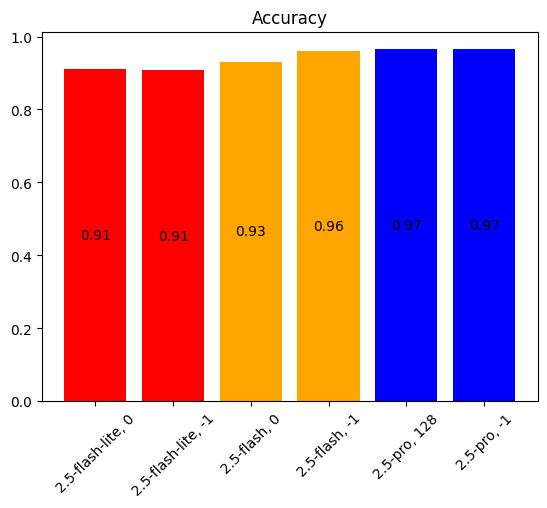

In [348]:
import matplotlib.pyplot as plt

all_evals = [
    flash_lite_evals_no_thinking, flash_lite_evals, flash_evals_no_thinking,
    flash_evals, pro_evals_minimal_thinking, pro_evals
]

names = [f"{eval['model'].replace("gemini-","").replace("-preview-06-17","")}, {eval['thinking_budget']}" for eval in all_evals]
avg_accs = [eval["avg_acc"] for eval in all_evals]
avg_costs = [eval["avg_cost"] for eval in all_evals]
avg_times = [eval["avg_time"] for eval in all_evals]

bar_colors = ['red', 'red', 'orange', 'orange', 'blue', 'blue']

fig, ax = plt.subplots()

bar = ax.bar(names, avg_accs, color=bar_colors)

ax.set_title('Accuracy')
ax.bar_label(bar, label_type='center', fmt="%.2f")
plt.xticks(rotation=45)

plt.show()

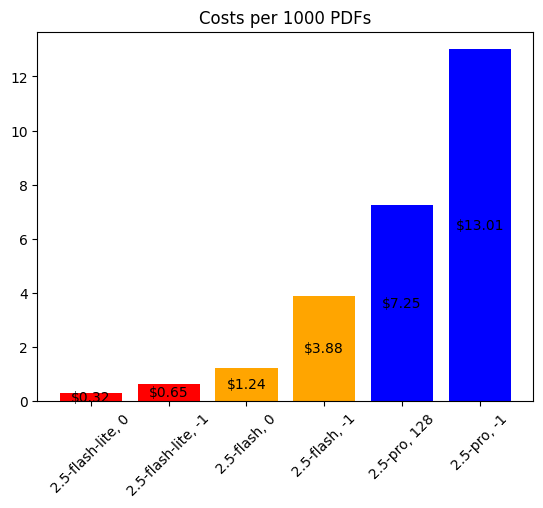

In [349]:
fig, ax = plt.subplots()
bar = ax.bar(names, [c*1000 for c in avg_costs], color=bar_colors)

ax.set_title('Costs per 1000 PDFs')
ax.bar_label(bar, label_type='center', fmt="$%.2f")
plt.xticks(rotation=45)

plt.show()

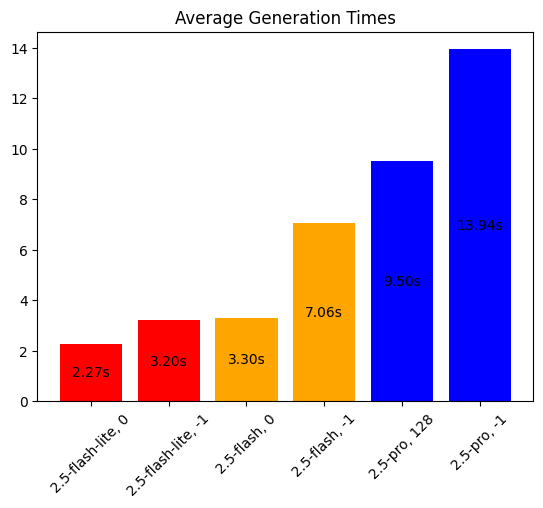

In [353]:
fig, ax = plt.subplots()
bar = ax.bar(names, avg_times, color=bar_colors)

ax.set_title('Average Generation Times')
ax.bar_label(bar, label_type='center', fmt="%.2fs")
plt.xticks(rotation=45)

plt.show()

### 👉 Takeaways

- 2.5 Pro best, but significantly more slow and expensive
- PDF extraction works well without thinking (Thinking only made a difference for 2.5 Flash)
- (For this task, speed might be less important)
- If we do not want to sacrifice accuracy, we need to choose 2.5 Pro, but we could disable thinking (more testing required)
- 2.5 Flash with thinking is a good trade-off (only slightly less accurate but 3-4x cheaper than Pro)
- If we can sacrifice accuracy, 2.5 Flash-Lite even without thinking is great & cheap with still over 91% acc

#### TODO: Test with different thinking budgets

## Test 2: Chat with large PDF

In [262]:
import httpx
URL = "https://storage.googleapis.com/deepmind-media/gemini/gemini_v2_5_report.pdf"
response = httpx.get(URL)
with open("gemini_v2_5_report.pdf", "wb") as f:
    f.write(response.content)

In [263]:
uploaded_pdf = client.files.upload(file="gemini_v2_5_report.pdf")

### 🚄Calculate TTFT with streaming

In [282]:
def stream_summarization(model, filename):
    chunks = []
    prompt = "Summarize this document in 10 bullet points. Then write 2 pages with the most important learnings from this report."
    start = time.time()
    response = client.models.generate_content_stream(
        model=model,
        contents=[prompt, uploaded_pdf],
        config={"thinking_config": {"thinking_budget": 0}}
    )

    for chunk in response:
        if not chunks:
            elapsed = time.time() - start
            print(f"Time to first response: {elapsed}")
        print(chunk.text)
        chunks.append(chunk.text)

    elapsed = time.time() - start
    print(f"Total time: {elapsed}")

    with open(filename, "w") as f:
        f.write("".join(chunks))

In [283]:
stream_summarization(GEMINI_2_5_FLASH, "report_summary-flash.txt")

Time to first response: 10.414530038833618
Here is a summary of the
 document in 10 bullet points, followed by a two-page learning report
.

## Summary of the Document (10 Bullet Points):

1.  **Gemini 2.X Model Family:** Google DeepMind introduces the Gemini 2.X model family, including Gemini 2.5 Pro (most
 capable), Gemini 2.5 Flash (efficient), Gemini 2.0 Flash, and Flash-Lite (fastest/cost-efficient).
2.  **Advanced Capabilities:** Gemini 2.5 Pro demonstrates state-of-the-art
 performance in coding, reasoning, and multimodal understanding, including processing up to 3 hours of video content.
3.  **Core Features:** All Gemini 2.X models are natively multimodal, support long context inputs (>1 million tokens), and have
 native tool-use support, enabling complex agentic workflows.
4.  **"Thinking" Mechanism:** Gemini Thinking models are trained with Reinforcement Learning to use additional inference-time compute for more accurate answers, allowing for tens of thousands of forward pass

In [284]:
stream_summarization(GEMINI_2_5_FLASH_LITE, "report_summary-flash-lite.txt")

Time to first response: 8.482915163040161
Here are 
10 bullet points summarizing the document:

*   **Gemini 2.
X Model Family Introduction:** The report introduces Gemini 2.5 Pro and Gemini 2.5 Flash, building upon earlier Gemini 2.0 Flash and Flash-Lite models, to represent a new generation of highly capable AI models.
*   
**Gemini 2.5 Pro's Advancements:** Gemini 2.5 Pro is described as the most capable model yet, achieving state-of-the-art performance in frontier coding and reasoning benchmarks, alongside enhanced multimodal understanding and the
 ability to process up to 3 hours of video.
*   **Gemini 2.5 Flash's Role:** Gemini 2.5 Flash is presented as a hybrid reasoning model with a controllable thinking budget, balancing quality, cost, and
 latency, making it suitable for complex tasks.
*   **Pareto Frontier Coverage:** The entire Gemini 2.X family spans the Pareto frontier of model capability versus cost, offering a range of options for users.
*   **Natively Mult
imodal and L

### 👉 Takeaways

- 1.2x faster TTFT for Flash-Lite, but this can heavily depend on the input and output size
- 2x faster total generation for Flash-Lite, but this can heavily depend on the input and output size
- *"Gemini 2.5 Flash-Lite independent benchmarks: ~5x cheaper and ~1.7x faster than regular Flash but with reduced intelligence"* [Source](https://x.com/ArtificialAnlys/status/1935427194882552148)

## Test 3: Generate an SVG of a pelican riding a bicycle

Credits to Simon Willison for the idea:

- [The last six months in LLMs, illustrated by pelicans on bicycles](https://simonwillison.net/2025/Jun/6/six-months-in-llms/)
- [Trying out the new Gemini 2.5 model family](https://simonwillison.net/2025/Jun/17/gemini-2-5/)

In [9]:
def generate_pelican(model, thinking_budget, filename):
    start = time.time()
    response = client.models.generate_content(
        model=model,
        contents="Generate an SVG of a pelican riding a bicycle. Use width=800 and height=600. Return only the SVG code and nothing else",
        config={"thinking_config": {"thinking_budget": thinking_budget}}
    )
    end = time.time()

    svg = response.text
    if svg.startswith("```svg\n"):
        svg = svg.lstrip("```svg\n")
    if svg.startswith("```xml\n"):
        svg = svg.lstrip("```xml\n")
    if svg.endswith("```"):
        svg = svg.rstrip("```")

    cost = calc_cost(model, response.usage_metadata)

    print(f"SVG generation with {model}")
    print(f"Cost: ${cost:.8f} , or {cost*100:.2f}¢")
    print(f"Time: {end-start:.2f}s")

    Path(filename).unlink(missing_ok=True)

    with open(filename, "w") as f:
        f.write(svg)

In [13]:
from IPython.display import SVG, display

SVG generation with gemini-2.5-flash-lite-preview-06-17
Cost: $0.00065410 , or 0.07¢
Time: 3.55s


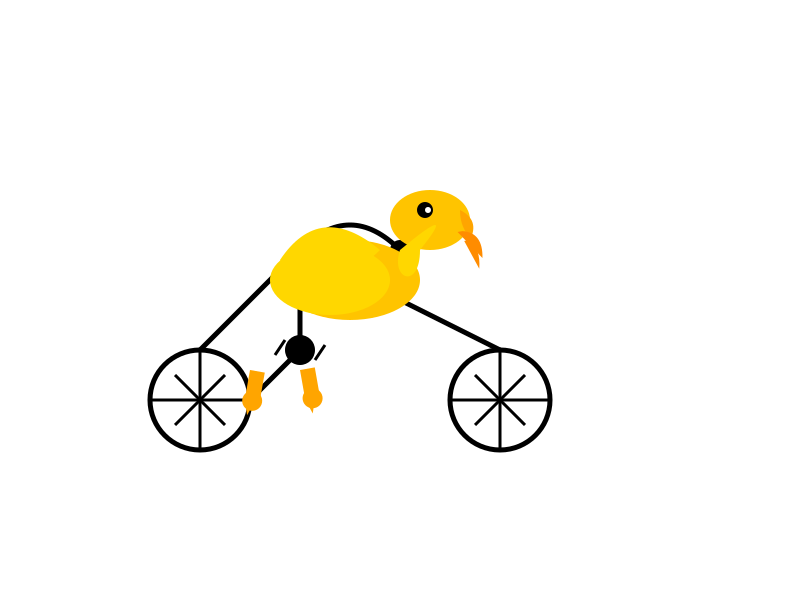

In [20]:
generate_pelican(GEMINI_2_5_FLASH_LITE, 0, "pelican-lite-no-thinking.svg")

display(SVG("pelican-lite-no-thinking.svg"))

SVG generation with gemini-2.5-flash-lite-preview-06-17
Cost: $0.00605050 , or 0.61¢
Time: 31.14s


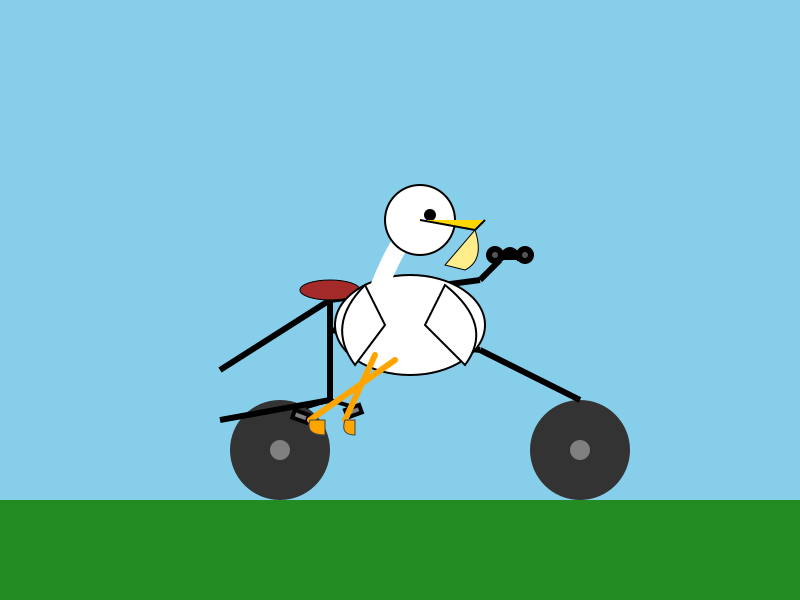

In [21]:
generate_pelican(GEMINI_2_5_FLASH_LITE, -1, "pelican-lite-thinking.svg")

display(SVG("pelican-lite-thinking.svg"))

SVG generation with gemini-2.5-flash
Cost: $0.00506990 , or 0.51¢
Time: 9.76s


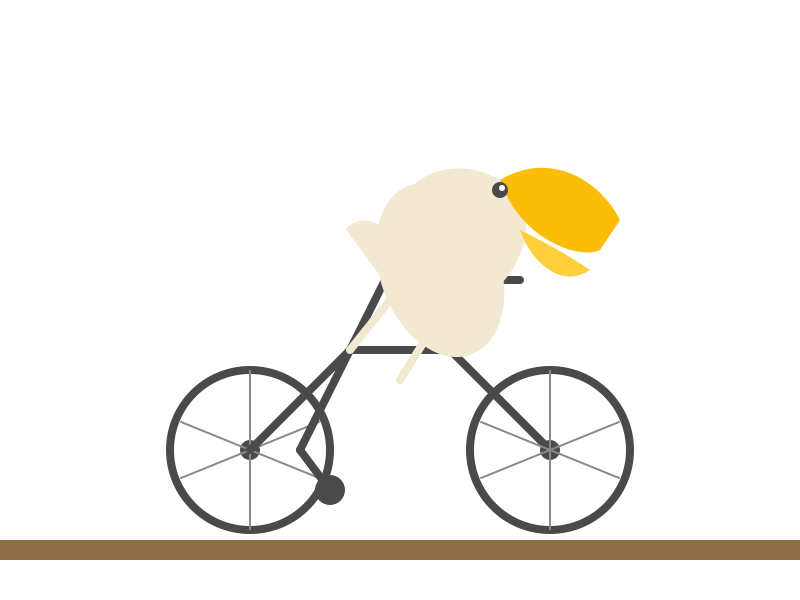

In [22]:
generate_pelican(GEMINI_2_5_FLASH, 0, "pelican-flash-no-thinking.svg")

display(SVG("pelican-flash-no-thinking.svg"))

SVG generation with gemini-2.5-flash
Cost: $0.04002240 , or 4.00¢
Time: 64.75s


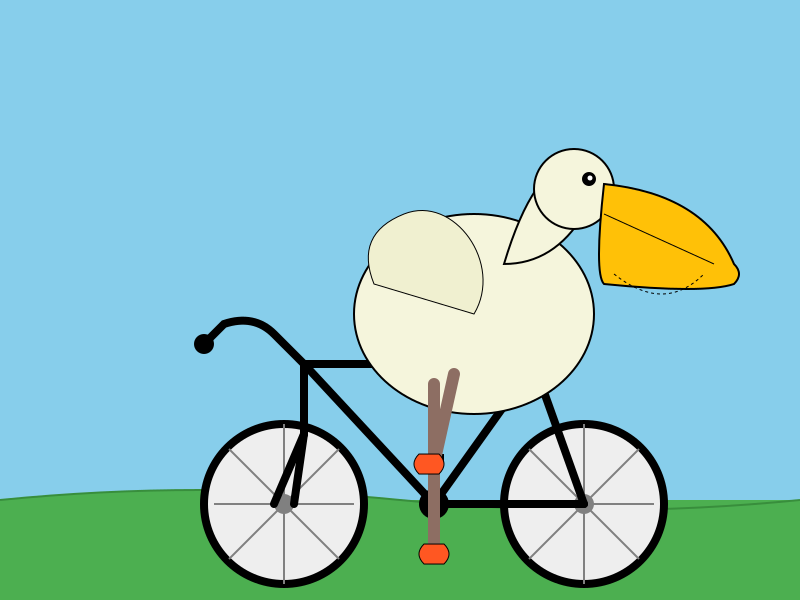

In [23]:
generate_pelican(GEMINI_2_5_FLASH, -1, "pelican-flash-thinking.svg")

display(SVG("pelican-flash-thinking.svg"))

SVG generation with gemini-2.5-pro
Cost: $0.02589125 , or 2.59¢
Time: 24.96s


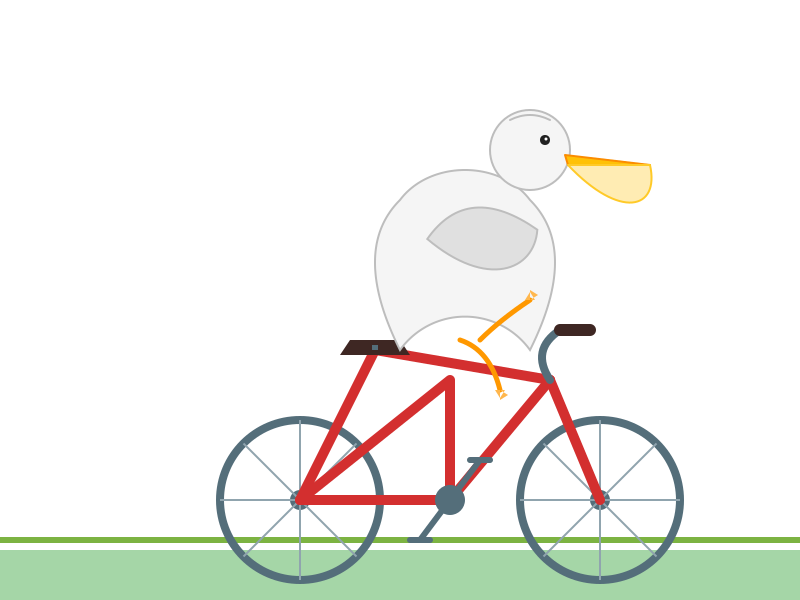

In [14]:
generate_pelican(GEMINI_2_5_PRO, 128, "pelican-pro-minimal-thinking.svg")

display(SVG("pelican-pro-minimal-thinking.svg"))

SVG generation with gemini-2.5-pro
Cost: $0.11421125 , or 11.42¢
Time: 106.74s


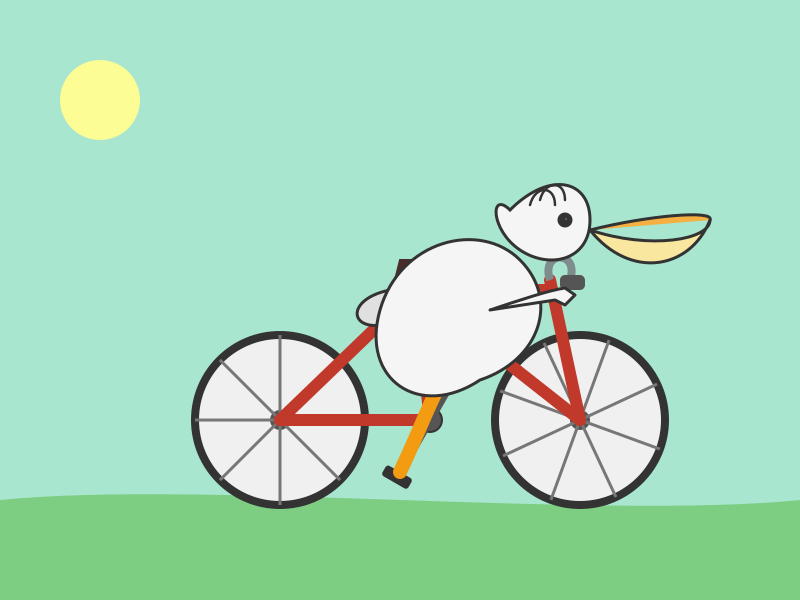

In [16]:
generate_pelican(GEMINI_2_5_PRO, -1, "pelican-pro-thinking.svg")

display(SVG("pelican-pro-thinking.svg"))

### 👉 Takeaways

Subjective SVG quality rating:

- Gemini 2.5 Pro is the best
- Gemini 2.5 Flash with thinking enabled also looks good